# Binary Classification exercise

click [here](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/02_pytorch_classification_exercise_solutions.ipynb) to read the official solutions

# Setup

In [1]:
# Import torch
import torch
import sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

!pip -q install torchmetrics
from torchmetrics import Accuracy
print("\nAll modules are installed correctly")


All modules are installed correctly


In [2]:
# Hyperparaneters
RANDOM_SEED = 42
TEST_SIZE = 0.2
LEARNING_RATE = 0.1
NUM_SAMPLES = 1000
COLOR_MAP = plt.cm.RdYlBu
print("\nAll hyperparaneters are defined correctly")


All hyperparaneters are defined correctly


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}\n")
!nvidia-smi

Using device: cuda

Tue Nov  8 10:37:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                    

# Data Preparation

In [4]:
# Create a dataset with Scikit-Learn's make_moons()
X, y = make_moons(
    n_samples=NUM_SAMPLES,
    shuffle=True,
    noise=0.08,
    random_state=RANDOM_SEED
)

print(
f'''
First 10 values of X:
{X[:10]}

First 10 values of y:
{y[:10]}
'''
)


First 10 values of X:
[[-0.0394303   0.42899361]
 [ 1.00989032 -0.43517392]
 [ 0.88235865 -0.30350408]
 [ 0.32425586 -0.42801604]
 [-0.83683369  0.53326877]
 [ 0.60394469 -0.27397197]
 [ 0.28889172 -0.2035512 ]
 [-0.04421384  0.46531253]
 [ 1.61058644 -0.29716027]
 [ 0.69877183  0.83816832]]

First 10 values of y:
[1 1 1 1 0 1 1 1 1 0]



In [5]:
# Turn data into a DataFrame
data = pd.DataFrame({
    "X0": X[:, 0],
    "X1": X[:, 1],
    "y": y
})

data.head(10)

,X0,X1,y
0,-0.039430,0.428994,1
1,1.009890,-0.435174,1
2,0.882359,-0.303504,1
3,0.324256,-0.428016,1
4,-0.836834,0.533269,0
5,0.603945,-0.273972,1
6,0.288892,-0.203551,1
7,-0.044214,0.465313,1
8,1.610586,-0.297160,1
9,0.698772,0.838168,0


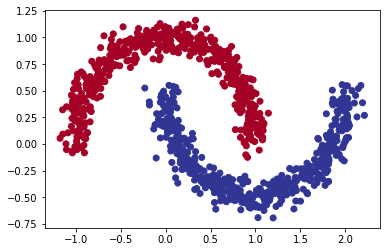

In [6]:
# Visualize the data on a scatter plot
plt.scatter(data["X0"], data["X1"], c=y, cmap=COLOR_MAP)

In [7]:
# Turn data into tensors of dtype float
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
print("X, y numpy.array (float 64) converted to torch.tensor (Float 32)")

X, y numpy.array (float 64) converted to torch.tensor (Float 32)


In [8]:
# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_SEED)

print(
f'''
Train {(1- TEST_SIZE) * 100:.0f}% / Test { (TEST_SIZE) * 100:.0f}%

Length of X_train: {len(X_train)}
Length of y_train: {len(y_train)}

Length of X_test: {len(X_test)}
Length of y_test: {len(y_test)}
'''
)


Train 80% / Test 20%

Length of X_train: 800
Length of y_train: 800

Length of X_test: 200
Length of y_test: 200



# Model Building

In [9]:
# multi-class classification model implementation
class MoonModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):

    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(input_features, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [10]:
# Create an instance of the model
model = MoonModel(
    input_features=2,
    output_features=1,
    hidden_units=10
)

# send model to target device
model.to(device)
print(f'''{model} device: {next(model.parameters()).device}''')

MoonModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
) device: cuda:0


# Model Training

In [11]:
# Reproducibility
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup accuracy function
accuracy_fn = Accuracy().to(device)

# Setup optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Put data to target device 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Set the number of epochs
epochs = 5000

# Training and evaluation loop
for epoch in range(epochs + 1):
    model.train()

    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_probs = torch.sigmoid(y_logits)
    y_pred = torch.round(y_probs) 

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_pred, y_train.int())

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step() 

    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze()
        test_probs = torch.sigmoid(test_logits)
        test_pred = torch.round(test_probs) 

        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(test_pred, y_test.int())
  
  # Print out what's this happenin'
    if epoch % 250 == 0:
        print(f"Epoch: {epoch}   |   Loss: {loss:.4f}, Acc: {acc:.2f}%   |   Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%\n")

Epoch: 0   |   Loss: 0.7149, Acc: 0.50%   |   Test Loss: 0.7147, Test Acc: 0.50%

Epoch: 250   |   Loss: 0.2118, Acc: 0.91%   |   Test Loss: 0.2060, Test Acc: 0.92%

Epoch: 500   |   Loss: 0.1198, Acc: 0.95%   |   Test Loss: 0.1132, Test Acc: 0.97%

Epoch: 750   |   Loss: 0.0522, Acc: 0.99%   |   Test Loss: 0.0453, Test Acc: 0.99%

Epoch: 1000   |   Loss: 0.0267, Acc: 1.00%   |   Test Loss: 0.0212, Test Acc: 1.00%

Epoch: 1250   |   Loss: 0.0170, Acc: 1.00%   |   Test Loss: 0.0128, Test Acc: 1.00%

Epoch: 1500   |   Loss: 0.0122, Acc: 1.00%   |   Test Loss: 0.0088, Test Acc: 1.00%

Epoch: 1750   |   Loss: 0.0094, Acc: 1.00%   |   Test Loss: 0.0066, Test Acc: 1.00%

Epoch: 2000   |   Loss: 0.0075, Acc: 1.00%   |   Test Loss: 0.0051, Test Acc: 1.00%

Epoch: 2250   |   Loss: 0.0061, Acc: 1.00%   |   Test Loss: 0.0040, Test Acc: 1.00%

Epoch: 2500   |   Loss: 0.0052, Acc: 1.00%   |   Test Loss: 0.0033, Test Acc: 1.00%

Epoch: 2750   |   Loss: 0.0045, Acc: 1.00%   |   Test Loss: 0.0028, Tes

# Model Predictions

In [12]:
model.eval()
with torch.inference_mode():
  y_logits = model(X_test.to(device)).squeeze()

# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.sigmoid(y_logits).squeeze()

# Convert our model's prediction probabilities to prediction labels
y_preds = torch.round(y_pred_probs).squeeze()

print(
f'''
y logits:
{y_logits[:5]} 

y prediction probabilities:
{y_pred_probs[:5]} 

y prediction lables:
{y_preds[:5]}

y test:
{y_test[:5]}

accuracy: {accuracy_fn(y_preds, y_test.int())}
'''
)


y logits:
tensor([ 13.4865, -15.3127,   7.5792, -17.2732,  12.8277], device='cuda:0') 

y prediction probabilities:
tensor([1.0000e+00, 2.2377e-07, 9.9949e-01, 3.1502e-08, 1.0000e+00],
       device='cuda:0') 

y prediction lables:
tensor([1., 0., 1., 0., 1.], device='cuda:0')

y test:
tensor([1., 0., 1., 0., 1.], device='cuda:0')

accuracy: 1.0



# Decision Boudaries

In [13]:
def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

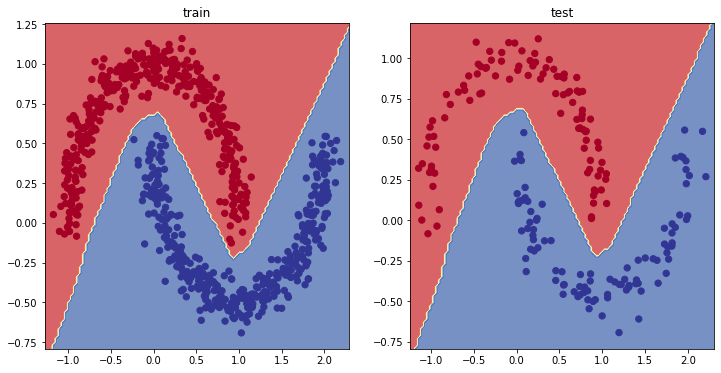

In [14]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model, X_test, y_test)